In [1]:
%matplotlib inline
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
MIN_INT_VALUE = -sys.maxsize - 1

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import restrictactions as ra
n_states = 750
n_actions = 25


/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Baseline dataset
train_set = pd.read_csv('../../data/train_scaled_encoded.csv')
test_set = pd.read_csv('../../data/test_scaled_encoded.csv')

In [3]:
# Features used to drive expert selection
train_input = pd.read_csv('../../data/train_input_features.csv')
test_input = pd.read_csv('../../data/test_input_features.csv')
test_input.columns

Index(['num_bloc', 'delta_sofa', 'delta_lactate', 'intermediate_reward'], dtype='object')

In [4]:
# Calculated state for each row in baseline
train_state_list = pkl.load(open('../../data/classify_state/train_states.pkl', 'rb'), encoding='latin1')
train_set['state'] = train_state_list
test_state_list = pkl.load(open('../../data/classify_state/test_states.pkl', 'rb'), encoding='latin1')
test_set['state'] = test_state_list

In [5]:
# Map actions to a single value in [0..24]
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv, vaso)] = count
        count += 1
        
def label_action(row):
    return action_map[(row['iv_input'],int(row['vaso_input']))]

train_set['phy_action'] = train_set.apply(lambda row: label_action(row),axis=1)
test_set['phy_action'] = test_set.apply(lambda row: label_action(row),axis=1)

In [6]:
# add in kernel policy
kernel_policy = pkl.load(open('../../data/test_kernel_policy_transformed.pkl', 'rb'), encoding='latin1')
test_set['kernel_action'] = kernel_policy[:,3].astype(int)

In [7]:
# add in DQN policy
train_dqn_policy = pd.DataFrame({'dqn_action':
                           pkl.load(open('../../data/dqn/train_agent_actions_2m.pkl', 'rb'), encoding='latin1')})
test_dqn_policy = pd.DataFrame({'dqn_action':
                           pkl.load(open('../../data/dqn/test_agent_actions_2m.pkl', 'rb'), encoding='latin1')})

train_set = pd.concat([train_set,train_dqn_policy],axis=1)
test_set = pd.concat([test_set,test_dqn_policy],axis=1)


In [8]:
# Get baseline mortality
episodes = test_set.groupby('icustayid')
n_died = 0
n_episodes = 0
for name, transitions in episodes:
    n_episodes += 1
    rewards = transitions['reward'].tolist()
    if rewards[-1] < 0:
        n_died += 1

print ("Testing Set Baseline mortality: {0:.1%}".format(n_died / n_episodes))

episodes = train_set.groupby('icustayid')
n_died = 0
n_episodes = 0
for name, transitions in episodes:
    n_episodes += 1
    rewards = transitions['reward'].tolist()
    if rewards[-1] < 0:
        n_died += 1

print ("Training Set Baseline mortality: {0:.1%}".format(n_died / n_episodes))
   

Testing Set Baseline mortality: 5.1%
Training Set Baseline mortality: 9.6%


In [40]:
train_set.head(100)

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,vaso_input,iv_input,reward,icustayid,state,phy_action,dqn_action
0,0.029027,0.061212,0.224086,0.079448,0.052524,0.077151,0.103817,0.063714,0.032102,0.042459,...,0.057297,0.030372,0.047363,0,0.0,0.0,12.0,126,0,13
1,0.031518,0.078677,0.120369,0.040228,0.047623,0.104624,0.093498,0.073046,0.035958,0.056553,...,0.043883,0.036930,0.057726,0,0.0,0.0,12.0,233,0,15
2,0.030942,0.083416,0.106333,0.040481,0.039120,0.098819,0.077658,0.074696,0.041053,0.053553,...,0.041910,0.036587,0.067986,0,0.0,0.0,12.0,233,0,15
3,0.042970,0.050963,0.090261,0.093201,0.031332,0.057674,0.032040,0.054802,0.061447,0.053960,...,0.045784,0.041096,0.129189,0,0.0,15.0,12.0,264,0,15
4,0.064572,0.084793,0.065976,0.070753,0.063990,0.051591,0.050112,0.049624,0.092619,0.080058,...,0.061251,0.071471,0.039540,0,4.0,0.0,14.0,492,20,9
5,0.074025,0.079019,0.069797,0.068576,0.069831,0.043737,0.056884,0.073837,0.073740,0.075134,...,0.053812,0.067138,0.043424,0,3.0,0.0,14.0,458,15,9
6,0.067640,0.073252,0.077615,0.072775,0.074835,0.040598,0.054152,0.078552,0.073434,0.086740,...,0.054578,0.068782,0.045069,0,3.0,0.0,14.0,458,15,9
7,0.084182,0.069916,0.070347,0.069123,0.072279,0.034510,0.053141,0.090075,0.061658,0.072907,...,0.054276,0.064720,0.051236,0,2.0,0.0,14.0,514,10,10
8,0.113805,0.048466,0.068828,0.080646,0.059614,0.016070,0.028201,0.081736,0.072616,0.049215,...,0.057034,0.067416,0.083398,0,0.0,0.0,14.0,686,0,0
9,0.103441,0.079006,0.073327,0.083135,0.065522,0.030426,0.026677,0.059899,0.066019,0.055480,...,0.069394,0.072032,0.120818,0,0.0,0.0,14.0,57,0,0


In [10]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,vaso_input,iv_input,reward,icustayid,state,phy_action,kernel_action,dqn_action
0,0.044787,0.024944,0.059501,0.186372,0.099174,0.010116,0.015910,0.031792,0.063170,0.050696,...,0.082892,0.012378,0,4.0,0.0,61.0,376,20,0,19
1,0.048257,0.029508,0.033046,0.102542,0.107019,0.015018,0.014971,0.034197,0.057205,0.072662,...,0.096143,0.013473,0,4.0,0.0,61.0,146,20,0,0
2,0.041906,0.028968,0.028705,0.111719,0.098205,0.013579,0.012648,0.027884,0.074506,0.081935,...,0.103266,0.015244,0,4.0,0.0,61.0,187,20,5,0
3,0.040383,0.029019,0.029167,0.131740,0.099840,0.013389,0.012455,0.028260,0.072425,0.088626,...,0.117384,0.015660,0,4.0,0.0,61.0,187,20,5,0
4,0.045685,0.029040,0.027817,0.137894,0.106901,0.013968,0.012697,0.028393,0.073113,0.088150,...,0.123431,0.014925,0,4.0,0.0,61.0,187,20,20,0


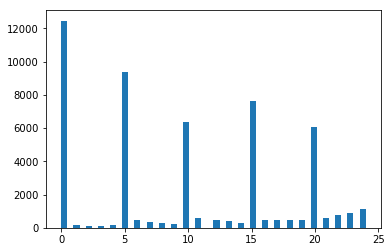

In [11]:
plt.hist(test_set['phy_action'],50)
pass

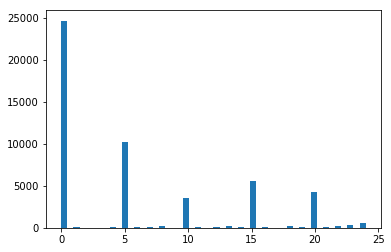

In [12]:
plt.hist(test_set['kernel_action'],50)
pass

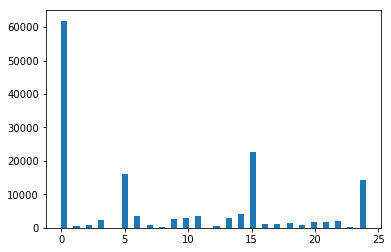

In [13]:
plt.hist(train_dqn_policy['dqn_action'],50)
pass

In [14]:
test_input.columns

Index(['num_bloc', 'delta_sofa', 'delta_lactate', 'intermediate_reward'], dtype='object')

In [15]:
test_set.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '198', '199', 'vaso_input', 'iv_input', 'reward', 'icustayid', 'state',
       'phy_action', 'kernel_action', 'dqn_action'],
      dtype='object', length=208)

(array([ 5862.,  5685.,  5319.,  4449.,  6001.,  4816.,  5435.,  4140.,
         4657.,  4495.]),
 array([   0. ,   74.9,  149.8,  224.7,  299.6,  374.5,  449.4,  524.3,
         599.2,  674.1,  749. ]),
 <a list of 10 Patch objects>)

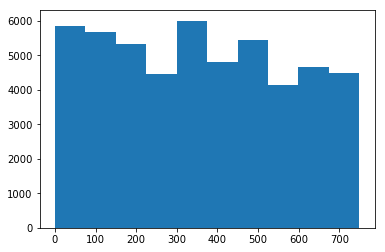

In [16]:
plt.hist(test_set['state'])

(array([ 17606.,  17926.,  16853.,  14000.,  16208.,  14909.,  15785.,
         11882.,  12994.,  12578.]),
 array([   0. ,   74.9,  149.8,  224.7,  299.6,  374.5,  449.4,  524.3,
         599.2,  674.1,  749. ]),
 <a list of 10 Patch objects>)

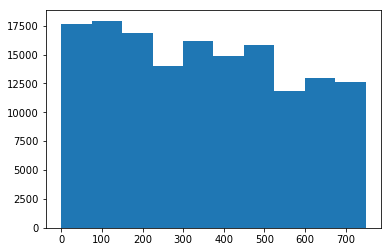

In [17]:
plt.hist(train_set['state'])

### Are intermediate reward predictive of state?

Answer: No, they aren't

In [18]:
orig_df = pd.read_csv('../../data/origin_train_clean.csv')

In [19]:
# X = pd.concat([train_input[['delta_sofa','delta_lactate','intermediate_reward']],
#                train_set['phy_action'].astype('category'),
#                orig_df['gender'].astype('category'),
#                (orig_df['age']/365.25).astype('int')],
#               ignore_index=True, axis=1)
# y = train_set['state'].astype('category')
# X.columns = ['delta_sofa','delta_lactate','intermediate_reward','phy_action','gender','age']
# X.head()

In [20]:
# Free up some memory
#del orig_df,train_state_list, test_state_list, kernel_policy, train_dqn_policy, test_dqn_policy

In [21]:
# to save time, 10% train, 90% test. RF was taking too long on the larger data set.
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.9)
# print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [22]:

# ntdict = {}
# for nt in [50,100]:
#     clf = RandomForestClassifier(n_estimators=nt,criterion="gini")
#     scores = cross_val_score(clf,X_train,y_train,cv=2)
#     ntdict[nt] = scores.mean()

In [23]:
# print (ntdict)

In [24]:
# del X_train, X_test, y_train, y_test, clf, scores, ntdict, X, y

### Terminal states

In [25]:
state_rewards = np.zeros((n_states))
state_reward_count = np.ones((n_states))
terminal_state = []
n_episodes = 0
for name, transitions in episodes:
    states = transitions['state'].tolist()
    rewards = transitions['reward'].tolist()
    terminal_state.append(states[-1])
    n_episodes += 1
    state_rewards[states[-1]] += rewards[-1]
    state_reward_count[states[-1]] += 1

state_rewards = state_rewards / state_reward_count

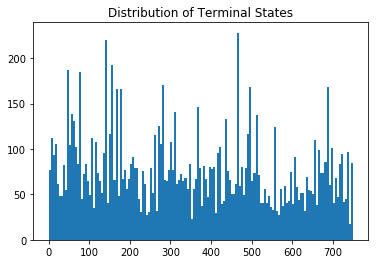

In [62]:
plt.hist(terminal_state,150)
plt.title("Distribution of Terminal States")
pass

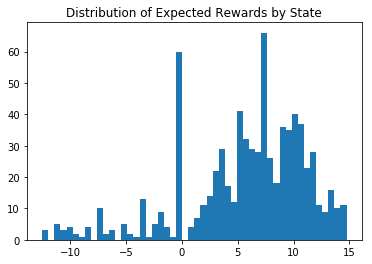

In [61]:
plt.hist(state_rewards,50)
plt.title("Distribution of Expected Rewards by State")
pass

Conclusion: there isn't a particular small set of states that are considered "terminal." However, some
terminal states have significantly more rewards than others. Choose the path that leads to the highest rewards.

### Restricted Actions

In [28]:
# import importlib
# importlib.reload(ra)

In [29]:
restrict_actions = ra.RestrictActions(n_states,n_actions)

In [30]:
restrict_actions.load_sas_as_episodes(episodes,'phy_action')

In [31]:
# Testing
# print (restrict_actions.get_actions(126,2))
# print (restrict_actions.get_consensus(126,0.2))
# print (restrict_actions.get_consensus(126,0.2))

In [32]:
dqn_restrict_actions = ra.RestrictActions(n_states,n_actions)
dqn_restrict_actions.load_sas_as_episodes(episodes,'dqn_action')

## Mixture of Experts Policy

Method:

* If there is physician consensus for a given action at a given state, simply choose it.
* If there is no consensus, walk the three action choices and pick the action that leads to
the state with the highest reward.

In [33]:
max_depth = 20
min_freq = 10
stats_different_actions = 0



In [34]:
def perform_action(state,action):
    reward = state_rewards[state]
    state = int(np.max(restrict_actions.sas_count[state,action]))
    return state, reward

In [58]:
def perform_best_action(state):
    global stats_dqn_chosen, stats_phy_chosen, stats_no_action, stats_different_actions
    max_reward = MIN_INT_VALUE
    dqn_reward = MIN_INT_VALUE
    phy_reward = MIN_INT_VALUE
    best_action = 0
    new_state = -1
    phy_best_action = -1
    dqn_best_action = -1
    
    for a in restrict_actions.get_actions(state,min_freq=min_freq):
        for s in range(len(restrict_actions.sas_count[state][a])):
            if restrict_actions.sas_count[state][a][s] < min_freq:
                continue
            #print ("phy states",np.where(restrict_actions.sas_count[state][a] > min_freq)[0].tolist())
            if state_rewards[s] > phy_reward:
                phy_reward = state_rewards[s]
                phy_best_action = a
                best_action = a
                new_state = s
                
    for a in dqn_restrict_actions.get_actions(state,min_freq=min_freq):
        for s in range(len(dqn_restrict_actions.sas_count[state][a])):
            if dqn_restrict_actions.sas_count[state][a][s] < min_freq:
                continue
            #print ("dqn states",np.where(dqn_restrict_actions.sas_count[state][a] > min_freq)[0].tolist())
            if state_rewards[s] > dqn_reward:
                dqn_reward = state_rewards[s]
                dqn_best_action = a
                best_action = a
                new_state = s
    
    #print("best phyaction:",phy_best_action,"best dqn action:",dqn_best_action)
    if phy_best_action != dqn_best_action:
        stats_different_actions += 1
        
    if phy_reward > dqn_reward:
        stats_phy_chosen += 1
        max_reward = phy_reward
    else:
        stats_dqn_chosen += 1
        max_reward = dqn_reward

    if new_state >= 0:
        #reward = state_rewards[new_state]
        return best_action, new_state, max_reward
    else:
        stats_no_action += 1
        return None, None, None

In [60]:
test_episodes = test_set.groupby('icustayid')

for physician_consensus in [0.3,0.5,0.7,0.9,0.95]:
    n_died = 0
    n_episodes = 0
    actions_taken = 1

    stats_phy_chosen = 0
    stats_dqn_chosen = 0
    stats_phy_consensus = 0
    stats_no_action = 0
    stats_different_actions = 0


    for name, transitions in test_episodes:
        n_episodes += 1
        if n_episodes > 500:
            break
        state = transitions['state'].tolist()[0]
        depth = 0 
        action_list = []
        state_list = []
        episode_reward = 0
        while True:
            if depth > max_depth:
                break
            depth += 1
            actions_taken += 1
            state = int(state)
            state_list.append(state)
            action = restrict_actions.get_consensus(state,physician_consensus)
            if action is None:
                action, state, reward = perform_best_action(state)
            else:
                state, reward = perform_action(state,action)
                stats_phy_consensus += 1
            if reward is None:
                break
            elif reward < 0:
                n_died += 1
                break
            else:
                action_list.append(action)
                episode_reward += reward
        #print ("actions:",action_list)
        #print ("states:",state_list)
        #print (n_episodes, "depth:", depth, episode_reward)
    total_choices = stats_phy_chosen + stats_dqn_chosen
    print ("physician and DQN actions differed {0:.1%} of the time".format(stats_different_actions/actions_taken))
    print ("| {0:.0%} ".format(physician_consensus), end="")
    print ("| {0:.1%} ".format(n_died / n_episodes), end="")
    print ("| {0:.1%} ".format(stats_phy_consensus / actions_taken), end="")
    print ("| {0:.1%} ".format(stats_phy_chosen/total_choices), end="")
    print ("| {0:.1%} | ".format(stats_dqn_chosen/total_choices))


physician and DQN actions differed 82.3% of the time
| 30% | 18.4% | 6.8% | 0.0% | 100.0% | 
physician and DQN actions differed 60.2% of the time
| 50% | 9.4% | 2.7% | 0.7% | 99.3% | 
physician and DQN actions differed 58.6% of the time
| 70% | 6.0% | 0.6% | 4.9% | 95.1% | 
physician and DQN actions differed 59.9% of the time
| 90% | 5.2% | 0.0% | 5.2% | 94.8% | 
physician and DQN actions differed 59.9% of the time
| 95% | 5.2% | 0.0% | 5.2% | 94.8% | 


Test Runs

|Physician Consensus | Mortality | Phy Consensus Occurred | Physician Policy Chosen | DQN Policy Chosen| Phy-DQN Disagree
|:---|---|---|---|---|
| 30% | 18.4% | 6.8% | 0.0% | 100.0% | 82.3 % | 
| 50% | 9.4% | 2.7% | 0.7% | 99.3% | 60.2% |
| 70% | 6.0% | 0.6% | 4.9% | 95.1% | 58.6 % |
| 90% | 5.2% | 0.0% | 5.2% | 94.8% | 59.9% |
| 95% | 5.2% | 0.0% | 5.2% | 94.8% | 59.9% |

(array([ 3.,  0.,  0.,  1.,  3.,  2.,  5.,  2.,  1.,  3.]),
 array([   0.        ,   29.43214286,   58.86428571,   88.29642857,
         117.72857143,  147.16071429,  176.59285714,  206.025     ,
         235.45714286,  264.88928571,  294.32142857]),
 <a list of 10 Patch objects>)

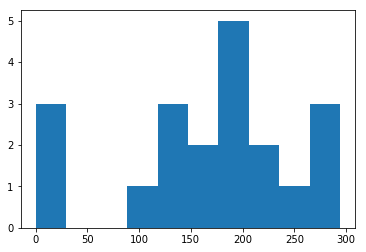

In [37]:
plt.hist(reward_dist)

(array([  4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.]),
 array([-15., -12.,  -9.,  -6.,  -3.,   0.,   3.,   6.,   9.,  12.,  15.]),
 <a list of 10 Patch objects>)

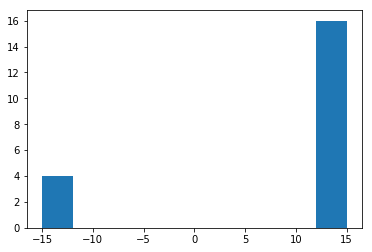

In [38]:
plt.hist(given_reward_dist)

In [39]:
792 / len(given_reward_dist)

39.6